Trajectory Recommendation using Markov Chain
=====

<a id='sec1'></a>

# 1. Overview

### Features
Transition Features
1. POI category (a transition matrix between different categories)
1. POI popularity (a transition matrix between different class of popularity)
1. POI pair distance (a transition matrix between different class of distance)

### Recommend Trajectories
Given (start, end) and trajectory length $l$ for a specific user $u$, we'll recommend a trajectory to user $u$ as follows:
- Compute/enumerate all trajectories of length $l$ with (start, end) as candidates
- Use a uniform prior for all candidates
- Compute the likelihood of candidates using the above transition features estimated from travelling sequences in the training set
- Sort candidates by their posterior probabilities (i.e. $\text{prior} \times \text{likelihood}$) in descending order
- Recommend a trajectory from the top $K$ (e.g. 5) candidates with probability proportional to its posterior

**NOTE** that we use the same leave-one-out cross validation approach described in the [ijcai15 paper](#https://sites.google.com/site/limkwanhui/publications/2015-IJCAI-personalTour.pdf?attredirects=0), concretely, for each user $u$ in the dataset, choose one trajectory (length >= 3) from all trajectories of $u$ uniformly at random, this trajectory is used as the ground truth to measure the performance of the recommendation (i.e. compute the [precision, recall and F1-score](./ijcai15.ipynb#sec2.1)), all other trajectories are used to train/estimate parameters. So the training set will change when iterating through all users.

<a id='sec2'></a>

# 2. Load Data

In [306]:
%matplotlib inline

import os
import re
import math
import random
import pickle
import pandas as pd
import numpy as np
import scipy.stats
#from numba import jit
from datetime import datetime
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [307]:
nfeatures = 8 # number of features
EPS = 1e-12 # smooth, deal with 0 probability
random.seed(123456789) # control random choice when splitting training/testing set

In [308]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [309]:
suffix = fvisit.split('-')[-1].split('.')[0]

In [310]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
#traj.head()

In [311]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


<a id='sec2.1'></a>

## 2.1 Compute POI Info

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [312]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [313]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [314]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
#poi_all.to_csv(fpoi, index=True)

<a id='sec2.2'></a>

## 2.2 Construct Travelling Sequences

In [315]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [316]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
#seq_user.head()

In [317]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

<a id='sec3'></a>

# 3. Compute Transition Probabilities

<a id='sec3.1'></a>

## 3.1 Basic Definitions

- $\text{Pr}(\text{Cat}_i \to \text{Cat}_j)$:
   the transition probability from a POI of category $\text{Cat}_i$ to a POI of category $\text{Cat}_j$
- $\text{Pr}(\text{Pop}_i \to \text{Pop}_j)$:
   the transition probability from a POI of Popularity class $\text{Pop}_i$ to a POI of Popularity class $\text{Pop}_j$
- $\text{Pr}(\text{Dist}_i \to \text{Dist}_j)$:
   the transition probability from a POI-POI pair with distance (between the two) class $\text{Dist}_i$ to a POI-POI pair with distance (between the two) class $\text{Dist}_j$

<a id='sec3.2'></a>

## 3.2 Transition Probabilities between POI Categories

We model transition probabilities between POI categories, i.e.
$\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_j})$.

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a small number (i.e. $0.1$ times the minimum value of that row) if there exists a zero cell.

In [318]:
def calc_poi_cat_transmat(seqid_set, poi_all, seq_all):
    poi_cats = poi_all['poiTheme'].unique().tolist()
    poi_cats.sort()
    poi_cat_transmat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    index=poi_cats, columns=poi_cats)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            cat1 = poi_all.loc[poi1, 'poiTheme']
            cat2 = poi_all.loc[poi2, 'poiTheme']
            poi_cat_transmat.loc[cat1, cat2] += 1
    return poi_cat_transmat

In [319]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()
        if len(nonzeroidx) < transmat.columns.shape[0]:
            minv = np.min(transmat.iloc[row, nonzeroidx])
            EPS = 0.1 * minv  # row-specific smooth factor
            transmat.iloc[row] += EPS
        else: # all zero in this row
            transmat.iloc[row] += 1  # uniform prior            
        rowsum = np.sum(transmat.iloc[row])
        #assert(rowsum > 0)
        transmat.iloc[row] /= rowsum
    return transmat        

<a id='sec3.3'></a>

## 3.3 Transition Probabilities between POI Popularity Classes

We model transition probabilities between POI popularities, i.e.
$\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_j})$
after discretizing POI popularities.

### 3.3.1 Discretize POI Popularity

It could be seen from the above plot that discretization based on equal frequency (quantiles) performs better than that based on equal width, to balance the complexity and accuracy, we choose `"quantile, nbins=9"`.

In [320]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'seqID']].copy()
    poi_info = poi_info.groupby('poiID').agg(np.size)
    poi_info.rename(columns={'seqID':'popularity'}, inplace=True)
    #poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    # POI popularity discretization: quantile based bins
    nbins = 9
    quantiles = np.round(np.linspace(0, 1, nbins+1), 2)[1:-1]
    bins_qt = [0]
    bins_qt.extend(poi_info['popularity'].quantile(quantiles))
    bins_qt.append(poi_info['popularity'].max() + 1)
    poi_info['popClass'] = np.digitize(poi_info['popularity'].get_values(), bins_qt)
    return poi_info.copy()

### 3.3.2 Compute Transition Probabilities

In [321]:
def calc_poi_pop_transmat(seqid_set, poi_all, seq_all):
    pop_class = poi_all['popClass'].unique().tolist()
    pop_class.sort()
    poi_pop_transmat = pd.DataFrame(data=np.zeros((len(pop_class), len(pop_class)), dtype=np.float), \
                                    index=pop_class, columns=pop_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        for j in range(len(seq)-1):
            poi1 = seq[j]
            poi2 = seq[j+1]
            pc1 = poi_all.loc[poi1, 'popClass']
            pc2 = poi_all.loc[poi2, 'popClass']
            poi_pop_transmat.loc[pc1, pc2] += 1
    return poi_pop_transmat

<a id='sec3.4'></a>

## 3.4 Transition Probabilities between POI Pair Distance Classes

We model transition probabilities between different POI pair distances, i.e.
$\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to \text{Dist}_{\text{POI}_{i} \to \text{POI}_j})$
after discretize POI pair distances.

### TODO: Improve the distance calculation using Google maps [distance API](https://developers.google.com/maps/documentation/distance-matrix/intro) with different [travel modes](https://developers.google.com/maps/documentation/distance-matrix/intro#travel_modes) demonstrated [here](https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/).

### 3.4.1 Discretize POI Pair Distance

In [322]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin( math.sqrt( \
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

we choose `quantile, nbins=10` to balance the complexity and accuracy.

In [323]:
def calc_poipair_distclass_mat(poi_all):
    poi_distmat = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                               index=poi_all.index, columns=poi_all.index)
    distdata = []
    for i in range(poi_all.index.shape[0]):
        poi1 = poi_all.index[i]
        for j in range(i+1, poi_all.index.shape[0]):
            poi2 = poi_all.index[j]
            dist = calc_dist(poi_all.loc[poi1, 'poiLon'], poi_all.loc[poi1, 'poiLat'], \
                             poi_all.loc[poi2, 'poiLon'], poi_all.loc[poi2, 'poiLat'])
            poi_distmat.loc[poi1, poi2] = dist
            poi_distmat.loc[poi2, poi1] = dist
            distdata.append(dist)
            
    # discretize POI pair distance: quantile based bins
    distdata = pd.Series(distdata)
    nbins = 10
    quantiles = np.round(np.linspace(0, 1, nbins+1), 2)[1:-1]
    bins_qt = [0]
    bins_qt.extend(distdata.quantile(quantiles))
    bins_qt.append(10*round(distdata.max()))
    
    poipair_distclass_mat = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.int), \
                                         index=poi_all.index, columns=poi_all.index)
    for i in range(poi_all.index.shape[0]):
        poi1 = poi_all.index[i]
        for j in range(i+1, poi_all.index.shape[0]):
            poi2 = poi_all.index[j]
            dc = np.digitize([poi_distmat.loc[poi1, poi2]], bins_qt)[0]
            poipair_distclass_mat.loc[poi1, poi2] = dc
            poipair_distclass_mat.loc[poi2, poi1] = dc
    return poipair_distclass_mat

### 3.4.2 Compute Transition Probabilities

Use POI pair that is **observed** in dataset to compute the transition matrix between different "class" of distances.

In [324]:
def calc_poipair_dist_transmat(seqid_set, seq_all, poipair_distclass_mat):
    dist_class = [poipair_distclass_mat.iloc[x, y] \
                  for x in range(poipair_distclass_mat.index.shape[0]) \
                  for y in range(x+1, poipair_distclass_mat.index.shape[0])]
    dist_class = np.unique(np.array(dist_class))
    poipair_dist_transmat = pd.DataFrame(data=np.zeros((len(dist_class), len(dist_class)), dtype=np.float), \
                                         index=dist_class, columns=dist_class)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) < 3: continue
        for j in range(1, len(seq)-1):
            poi1 = seq[j-1]
            poi2 = seq[j]
            poi3 = seq[j+1]
            dc1 = poipair_distclass_mat.loc[poi1, poi2]
            dc2 = poipair_distclass_mat.loc[poi2, poi3]
            poipair_dist_transmat.loc[dc1, dc2] += 1
    return poipair_dist_transmat

<a id='sec4'></a>

# 4. Compute Trajectory Likelihood

Log likelihood of trajectory $[\text{POI}_1, \text{POI}_2, \dots, \text{POI}_i, ..., \text{POI}_N]$ is defined as
\begin{align}
\text{logl} =& 
\sum_{i=1}^{N-1} \log(\text{Pr}(\text{Cat}_{\text{POI}_i} \to \text{Cat}_{\text{POI}_{i+1}})) + 
\sum_{i=1}^{N-1} \log(\text{Pr}(\text{Pop}_{\text{POI}_i} \to \text{Pop}_{\text{POI}_{i+1}})) + 
\sum_{i=2}^{N-1} \log(\text{Pr}(\text{Dist}_{\text{POI}_{i-1} \to \text{POI}_i} \to 
\text{Dist}_{\text{POI}_{i} \to \text{POI}_{i+1}})) \\
& + \log(\text{Pr}(\text{POI}_1)) 
\end{align}

where $\text{Pr}(\text{POI}_1)$ is the prior of $\text{POI}_1$ and we assume $\text{Pr}(\text{POI}_1)=1.0$, 10-based logarithm is used here.

In [325]:
def calc_seq_loglikelihood(seq, poi_all, poi_cat_transmat_log, poi_pop_transmat_log, \
                           poi_distclass_mat, poipair_dist_transmat_log):
    assert(len(seq) > 1)
    cat1 = poi_all.loc[seq[0], 'poiTheme']
    cat2 = poi_all.loc[seq[1], 'poiTheme']
    pc1  = poi_all.loc[seq[0], 'popClass']
    pc2  = poi_all.loc[seq[1], 'popClass']
    logL = poi_cat_transmat_log.loc[cat1, cat2] + poi_pop_transmat_log.loc[pc1, pc2]
    for j in range(1, len(seq)-1):
        poi1 = seq[j-1]
        poi2 = seq[j]
        poi3 = seq[j+1]
        cat2 = poi_all.loc[poi2, 'poiTheme']
        cat3 = poi_all.loc[poi3, 'poiTheme']
        pc2  = poi_all.loc[poi2, 'popClass']
        pc3  = poi_all.loc[poi3, 'popClass']
        dc12 = poi_distclass_mat.loc[poi1, poi2]
        dc23 = poi_distclass_mat.loc[poi2, poi3]
        logL += poi_cat_transmat_log.loc[cat2, cat3] + poi_pop_transmat_log.loc[pc2, pc3]
        #print(seq, dc12, dc23)
        logL += poipair_dist_transmat_log.loc[dc12, dc23]
    return logL

<a id='sec5'></a>

# 5. Trajectory Recommendation & Evaluation

Parameter estimation of the Markov Chain.

In [326]:
def estimate_parameter(seqid_set_training, poi_all, seq_all):
    # compute POI info using training set
    poi_info = calc_poi_info(seqid_set_training, seq_all, poi_all)
    
    # compute POI category transition matrix
    poi_cat_transmat = calc_poi_cat_transmat(seqid_set_training, poi_info, seq_all)
    poi_cat_transmat = normalise_transmat(poi_cat_transmat)
    poi_cat_transmat_log = np.log10(poi_cat_transmat)
    
    # compute POI popularity transition matrix    
    poi_pop_transmat = calc_poi_pop_transmat(seqid_set_training, poi_info, seq_all)
    poi_pop_transmat = normalise_transmat(poi_pop_transmat)
    poi_pop_transmat_log = np.log10(poi_pop_transmat)
    
    # compute POI pair distance transition matrix
    poipair_distclass_mat = calc_poipair_distclass_mat(poi_info)
    poipair_dist_transmat = calc_poipair_dist_transmat(seqid_set_training, seq_all, poipair_distclass_mat)
    poipair_dist_transmat = normalise_transmat(poipair_dist_transmat)
    poipair_dist_transmat_log = np.log10(poipair_dist_transmat)
    
    return (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)    

Enumerate trajectories of the same (start, end) and length (3, 4 or 5) with respect to an actual sequence.

In [327]:
def enum_seq345(start, end, length, poi_list): 
    assert(length in {3, 4, 5})
    p0 = start
    pN = end
    
    # enumerate sequences with length 3
    if length == 3:
        return [[p0, p, pN] \
                for p in poi_list if p not in {p0, pN}]
    
    # enumerate sequences with length 4
    if length == 4:
        return [[p0, p1, p2, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN}]
    
    # enumerate sequences with length 5
    if length == 5:
        return [[p0, p1, p2, p3, pN] \
                for p1 in poi_list if p1 not in {p0, pN} \
                for p2 in poi_list if p2 not in {p0, p1, pN} \
                for p3 in poi_list if p3 not in {p0, p1, p2, pN}]

In [328]:
def parse_seqstr(seqstr):
    term = re.sub('[ \[\]]', '', seqstr).split(',')
    return [int(x) for x in term]

With uniform prior, the posterior probability of trajectory is proportional to its likelihood.

In [329]:
def recommend_trajectory(start, end, length, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, \
                         poipair_distclass_mat, poipair_dist_transmat_log):    
    # enumerate trajectory
    poi_list = poi_info.index.tolist()
    enum_seqs = enum_seq345(start, end, length, poi_list)
    
    # compute log likelihood
    t1 = datetime.now()
    logL = Parallel(n_jobs=-2)(delayed(calc_seq_loglikelihood)\
           (seq, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)\
           for seq in enum_seqs)
    print('%d seconds used' % (datetime.now()-t1).total_seconds())
    
    # sanity check: passed
    #seq1 = [10, 21, 28, 22]
    #dc12 = poipair_distclass_mat.loc[seq1[0], seq1[1]]
    #dc23 = poipair_distclass_mat.loc[seq1[1], seq1[2]]
    #dc34 = poipair_distclass_mat.loc[seq1[2], seq1[3]]
    #s1 = poi_cat_transmat_log.loc[poi_info.loc[seq1[0], 'poiTheme'], poi_info.loc[seq1[1], 'poiTheme']] + \
    #     poi_cat_transmat_log.loc[poi_info.loc[seq1[1], 'poiTheme'], poi_info.loc[seq1[2], 'poiTheme']] + \
    #     poi_cat_transmat_log.loc[poi_info.loc[seq1[2], 'poiTheme'], poi_info.loc[seq1[3], 'poiTheme']] + \
    #     poi_pop_transmat_log.loc[poi_info.loc[seq1[0], 'popClass'], poi_info.loc[seq1[1], 'popClass']] + \
    #     poi_pop_transmat_log.loc[poi_info.loc[seq1[1], 'popClass'], poi_info.loc[seq1[2], 'popClass']] + \
    #     poi_pop_transmat_log.loc[poi_info.loc[seq1[2], 'popClass'], poi_info.loc[seq1[3], 'popClass']]
    #s2 = poipair_dist_transmat_log.loc[dc12, dc23] + poipair_dist_transmat_log.loc[dc23, dc34]
    #logL1 = calc_seq_loglikelihood(seq1, poi_info, poi_cat_transmat_log, poi_pop_transmat_log, \
    #                               poipair_distclass_mat, poipair_dist_transmat_log)
    #print(s1+s2, '==', logL1, '?')
    
    # dataframe of enumerated trajectories
    enum_seq_df = pd.DataFrame(data=np.array(logL), index=[str(x) for x in enum_seqs], columns=['logLikelihood'])
    
    # sort by loglikeilihood in descending order
    enum_seq_df.sort(columns=['logLikelihood'], ascending=False, inplace=True)
    
    # recommend trajectory with probability proportional to its posterior (i.e. likelihood when prior is uniform)
    probs = enum_seq_df['logLikelihood'].get_values()
    probs = np.exp(probs)
    probs /= np.sum(probs)
    sample = np.random.multinomial(1, probs) # catgorical/multinoulli distribution, multinomial distribution (n=1)
    seq_idx = sample.nonzero()[0][0]
    return parse_seqstr(enum_seq_df.index[seq_idx])

Use F1 measure defined [here](./ijcai15.ipynb#sec2.1) to evaluate the performance of recommender.

In [330]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    actset = set(seq_act)
    recset = set(seq_rec)
    intersect = actset & recset
    recall = len(intersect) / len(seq_act)
    precision = len(intersect) / len(seq_rec)
    F1score = 2. * precision * recall / (precision + recall)
    return F1score

<a id='sec6'></a>

# 6. Active Learning without Personalisation

<a id='sec5.1'></a>

### 5.1 Travelling Sequences Dataset Partition

Split dataset (travelling sequences with length 3/4/5) into training set (i.e. initial training) (~10%), annotation set (i.e. simulate user annotation)(~50%), evaluation set (a.k.a. test set) (~40%).

One problem found in experiment:
- when the initial training set is too small such that the travelling sequences in training set can not span all POIs, then the evaluation will fail. 

In [331]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
print(seq_stats.index.shape[0])

6057


In [332]:
seqid_set_exp = seq_stats[seq_stats['seqLen'].isin({3, 4, 5})].index
print(len(seqid_set_exp))

309


In [333]:
idx_range = np.arange(len(seqid_set_exp))
np.random.shuffle(idx_range)

In [334]:
num_train = round(len(seqid_set_exp) * 0.4)
num_annotate = round(len(seqid_set_exp) * 0.4)
print(num_train, num_annotate)

124 124


In [335]:
seqid_set_training = list(seqid_set_exp[idx_range[0:num_train]])
seqid_set_annotate = list(seqid_set_exp[idx_range[num_train:num_train+num_annotate]])
seqid_set_evaluate = list(seqid_set_exp[idx_range[num_train+num_annotate:]])

In [336]:
print(len(seqid_set_exp))
print(len(seqid_set_training))
print(len(seqid_set_annotate))
print(len(seqid_set_evaluate))

309
124
124
61


### 5.2 Random Baseline

Query strategy: choose a random example in annotation set to query (passive learning).

In [337]:
query_order = np.arange(len(seqid_set_annotate))
np.random.shuffle(query_order)

In [338]:
F1_mean_random = []
F1_std_random = []

Recommend trajectories using the initial training set and evaluate on test set.

In [ ]:
# estimate parameters
(poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
estimate_parameter(seqid_set_training, poi_all, seq_all)
# evaluate on test set
F1scores = []
for seqid in seqid_set_evaluate:
    seq_act = extract_seq(seqid, seq_all)
    seq_rec = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), poi_info, poi_cat_transmat_log, \
                                   poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
    F1 = calc_F1score(seq_act, seq_rec)
    F1scores.append(F1)
F1_mean_random.append(np.mean(F1scores))
F1_std_random.append(np.std(F1scores))

Evaluate the baseline on test set.

In [340]:
for idx in query_order:
    seqid = seqid_set_annotate[idx] # choose sequence to query
    seqid_set_training.append(seqid)   # add query result to training set, here just add the sequence id to training set
    (poi_info, poi_cat_transmat_log, poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log) = \
    estimate_parameter(seqid_set_training, poi_all, seq_all)  # estimate parameters
    # evaluate on test set
    F1scores = []
    for seqid in seqid_set_evaluate:
        seq_act = extract_seq(seqid, seq_all)
        seq_rec = recommend_trajectory(seq_act[0], seq_act[-1], len(seq_act), poi_info, poi_cat_transmat_log, \
                                       poi_pop_transmat_log, poipair_distclass_mat, poipair_dist_transmat_log)
        F1 = calc_F1score(seq_act, seq_rec)
        F1scores.append(F1)
    F1_mean_random.append(np.mean(F1scores))
    F1_std_random.append(np.std(F1scores))

0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
15 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
15 seconds used
-3.61774109415 -3.61774109415
0 seconds used
-3.61774109415 -3.61774109415
0 second

Plot the learning curve.

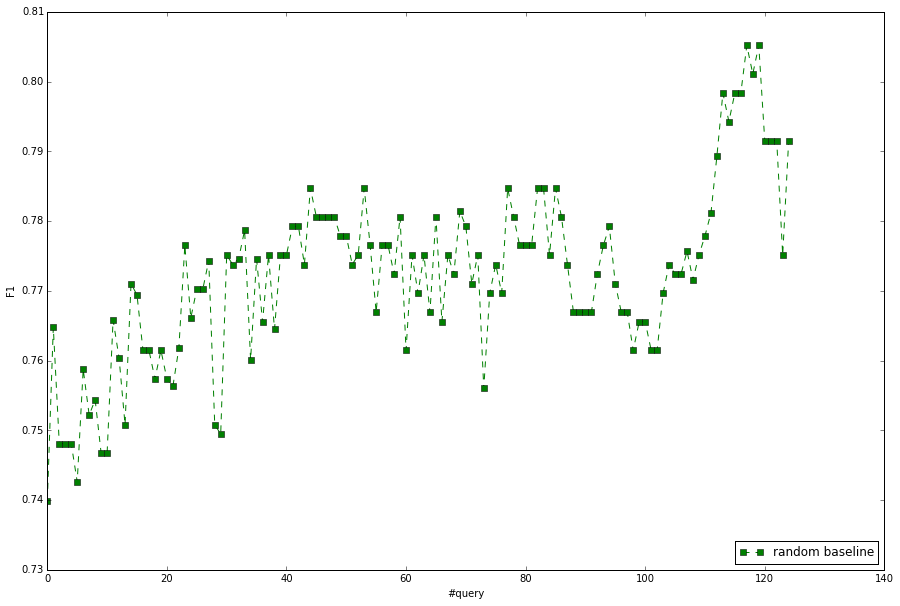

In [352]:
plt.figure(figsize=[15, 10])
plt.plot(np.arange(len(seqid_set_annotate)+1), F1_random, marker='s', color='g', linestyle='--', label='random baseline')
plt.xlabel('#query')
plt.ylabel('F1')
plt.legend(loc='lower right')